# Rate Networks

In [48]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import ConnectionPatch
import ipywidgets as widgets
from scipy import optimize as opt

%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

try:
    import brian2
except ImportError:
    !pip install brian2
    
from brian2 import *
prefs.codegen.target = 'numpy'


# This notebook

This notebook follows the lecture quite closely. We want to understand how to investigate 2D rate models. Therefore we 

* Investigate an example non-linearity, the sigmoidal Function. 

* Look at a simple, Feedforward dynamical system and how it evolves. 

* Investigate the phase plane and fixed points of a recurrent system in one dimenision. 

* Do the same in two dimensions.

* Make the comparison of a spiking network and a rate based network

## 1) An example non-linearity: The sigmoidal function

We take the following curve as an example: 

\begin{equation}
F(x;\alpha,\theta) = \left(1+\text{e}^{-\frac{x-\theta}{\alpha}}\right)^{-1} - \left(1+\text{e}^{\frac{\theta}{\alpha}}\right)^{-1}
\end{equation}

The last part ensures that the value at 0 is always 0, independent of the parameters. 
Below you find the implementation for the non-linearity and an interactive widget for you to explore how the curve behaves with respect to its parameters $\theta$ (the threshold) and $\alpha$ (the gain).

### Task 1

Please explore how the parameters influence the curve

In [2]:
def nonlinearity_f(x, alpha, theta):    
    return (1 + np.exp(-alpha*(x - theta)))**-1 - (1 + np.exp(alpha*theta))**-1

def interactive_f(alpha=0.2, theta=40):
    
    x_max = 80
    fig, ax = plt.subplots()
    X = np.linspace(-0.1,x_max,100)
    ax.plot(X, nonlinearity_f(X, alpha=alpha, theta=theta), color='#6baed6', linewidth = 3)
    
    y_theta = nonlinearity_f(theta, alpha=alpha, theta=theta)
    
    ax.plot([theta,theta],[0,y_theta],
           linestyle = '--', c = '#e34a33', linewidth=1, label = r'threshold $\theta$')
    
    # we want to visualize the gain of the 
    
    diff = 8
    
    ax.plot([theta-diff,theta+diff],[y_theta-diff*alpha/4, y_theta+diff*alpha/4],
           linestyle = '--', c = 'k', linewidth=1, label = r'linear function with gain $\alpha/4$')
    
    ax.set(
        title = 'F-I curve',
        xlabel = 'Input current',
        ylabel = 'Output rate',
        ylim = [-0.05,1.05],
        xlim = [-0.05*x_max,x_max*1.05]
    );
    ax.legend()
    
widgets.interactive(interactive_f, alpha = (0.01,1,0.01), theta=(0,60,10))

interactive(children=(FloatSlider(value=0.2, description='alpha', max=1.0, min=0.01, step=0.01), IntSlider(val…

## Recurrent rate model

We now look at our population rate model with recurrent connections. 

<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_8/static/rate_model_recurrent.png" width="250"/>
</div>

The differential equation for this network describes how the external input and the recurrent input (the activity times the recurrent weight) is filtered through the non-linearity (F-I curve) and then defines the activity that the system is trying to reach:

$\tau\,\frac{dr}{dt} = -r + F(w\,r+I_{\text{ext}})$


Below, we create a class (RecurrentNetwork) that allows us to investigate the system.

In the method 'compute_dr_dt' we use the differential equation above. 

The method 'run_simulation' allows us to run a simulation with the current paramters.

We can viusalize the results of this simulation ('show_simulation_results') and we can look at the phase plane of the system (given the current parameters) with the method 'show_phase_plane'.

### Task 2

Please go through the class and check especially that you understand the implementation of the differential equation.

In [68]:
class RecurrentNetwork(object):
    """
    This class can create a recurrent network, run simulations and visualize the results
    """
    def __init__(self, 
                    w = 5,
                    alpha = 4,
                    theta = 13,
                    max_rate = 1,
                    tau = 11,
                    dt = 1,
                    I_ext = 0,
    ):
        '''This function is executed when we create an object from that class'''
        super(RecurrentNetwork, self).__init__()
        
        self.w = w
        self.alpha = alpha
        self.theta = theta
        self.max_rate = max_rate
        self.tau = tau
        self.dt = dt
        self.I_ext = I_ext
        

        self.t_list = []
        self.r_list = []
        

    def update_external_current(I_ext):
        self.I_ext = I_ext
        
    def compute_drdt(self, r):
        # Calculate drdt
        drdt = (-r + self.max_rate*nonlinearity_f(self.w * r + self.I_ext, self.alpha, self.theta)) / self.tau
        return drdt


    def run_simulation(self, r_0 = 0.3, time_steps = 1500):

        self.t_list = [0]
        self.r_list = [r_0]

        for ii in range(time_steps):
            drdt = self.compute_drdt(r = self.r_list[-1])
            self.r_list.append(self.r_list[-1] + self.dt*drdt)
            self.t_list.append(self.t_list[-1]+self.dt)


    def show_simulation_result(
        self,
        color = 'k',
        linewidth = 2,
        ax = None):
        if ax == None:
            fig, ax = plt.subplots()

        ax.plot(self.t_list, self.r_list, color=color, linewidth=linewidth)
        ax.set_xticks([0,75,150])
        ax.set_xticklabels([0,75,150],fontsize=14)
        ax.set_yticks([0,0.5,1])
        ax.set_yticklabels([0,0.5,1],fontsize=14)
        ax.set_xlabel('time in ms', fontsize=16)
        ax.set_ylabel('firing rate $r$', fontsize=16)

        return ax
    
    def show_phase_plane(self, ax = None):
        
        # Define a vector of r values and the simulation parameters
        r = np.linspace(0, 1, 1000)

        # Compute dr/dt
        drdt = self.compute_drdt(r)
    
        if ax == None:
            fig, ax = plt.subplots()
        ax.plot(r, drdt)
        ax.plot([0,1],[0,0],linestyle = '--', color = 'k')

        x_ticks = [0,0.5,1]
        y_ticks = [np.round(ii,5) for ii in np.linspace(-0.015,0.015,11) if ii < np.max(drdt) and ii > np.min(drdt)]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,fontsize=14)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks,fontsize=14)
        ax.set_xlabel('$r$', fontsize=16, fontweight='bold')
        ax.set_ylabel(r'$\frac{dr}{dt}$', fontsize=22, rotation=0, fontweight='bold')
        
    def show_phase_plane_turned(self, ax1= ax1, ax2=ax2):
    

        # Define a vector of r values and the simulation parameters
        r = np.linspace(0, 1, 1000)

        # Compute dr/dt
        drdt = self.compute_drdt(r)
    
        X = np.linspace(0.,self.theta*2.3,500)
        ax1.plot(X, nonlinearity_f(X, alpha=self.alpha, theta=self.theta), color='k', linewidth = 1)
        y_ticks = [0,0.5,1]
        ax1.set_yticks(y_ticks)
        ax1.set_yticklabels(y_ticks,fontsize=14)
        ax1.set_ylabel('$r$', fontsize=22, rotation=0, fontweight='bold')

        ax2.plot(drdt, r)
        ax2.plot([0,0],[0,1],linestyle = '--', color = 'k')

        x_ticks = [np.round(ii,5) for ii in np.linspace(-0.015,0.015,11) if ii < np.max(drdt) and ii > np.min(drdt)]

        ax2.set_xticks(x_ticks)
        ax2.set_xticklabels(x_ticks,fontsize=14)
        
        ax2.set_xlabel(r'$\frac{dr}{dt}$', fontsize=22, fontweight='bold')

### Phase plane

We can now simply plot the phase plane of our 1D dynamical system

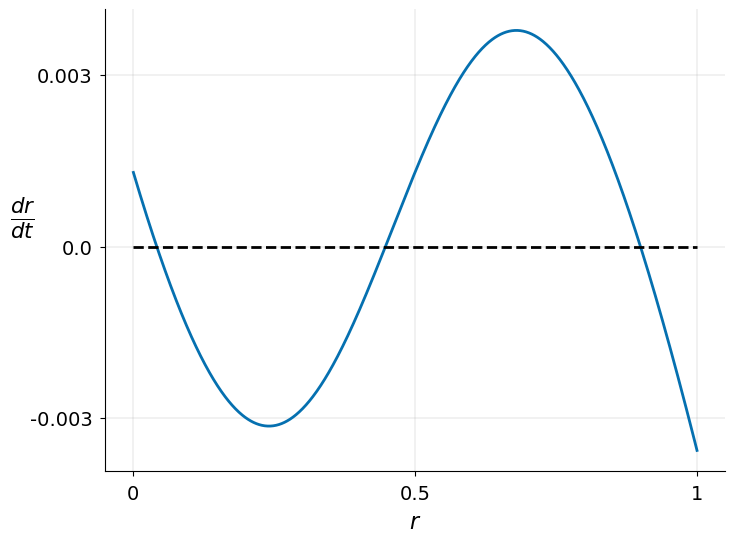

In [69]:
example = RecurrentNetwork(w = 5, alpha = 1.2, theta = 2.8, tau = 20, I_ext = 0.5)
example.show_phase_plane()

### Time evolution of the dynamical system

We can also run the simulation in our system and look at the time dynamics

<AxesSubplot:xlabel='time in ms', ylabel='firing rate $r$'>

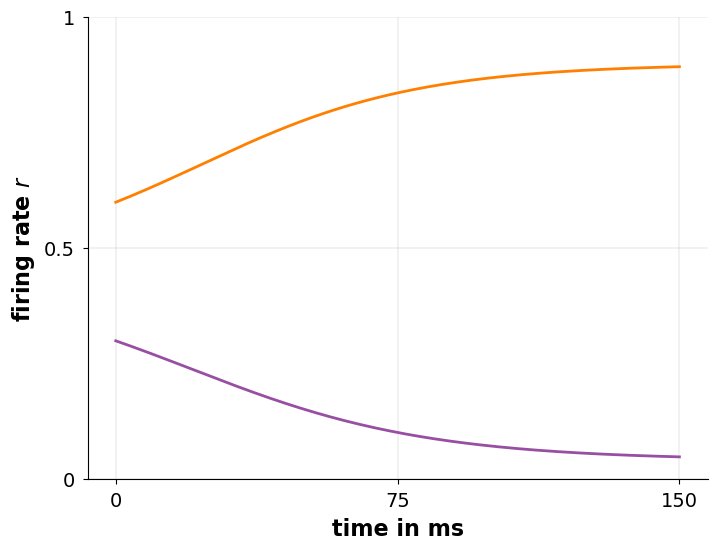

In [5]:
example = RecurrentNetwork(w = 5, alpha = 1.2, theta = 2.8, tau = 20, I_ext = 0.5)
example.run_simulation(r_0 = 0.3, time_steps = 150)
ax = example.show_simulation_result(color = '#984ea3',ax = None)
example.run_simulation(r_0 = 0.6, time_steps = 150)
example.show_simulation_result(color = '#ff7f00',ax = ax )

## Fixed points

Now we look at the fixed points of our system. They are the points where the system does not change anymore. To find these points, we use the scipy function _opt.root_. However, finding roots is not a trivial task. To find all the roots of our simple system, we start with multiple guesses (distributed across the input space between 0 and 1) 

### Task 3
See if you can understand the implementation of our fixed point search. When you execute the interactive widget, you can see how the fixed points and the trajectories change for different parameter combinations. See if you can understand how each paramter impacts the dynamical system.

In [50]:
def mulitple_starting_conditions(w = 5, alpha = 1.2, theta = 2.8, tau = 20, I_ext = 0.5):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
    example = RecurrentNetwork(w = w, alpha = alpha, theta = theta, tau = tau, I_ext = I_ext)
    
    correct_fps = []
    for x_guess in np.linspace(0,1,20):
        x_fp =  np.round(opt.root(example.compute_drdt, x_guess).x.item(),7)
        # check if its a real fixed point
        if np.abs(example.compute_drdt(x_fp)) < 1e-6:
            if x_fp not in correct_fps:
                correct_fps.append(x_fp)
    
    
    if len(correct_fps) == 3:
        scatter_color = ['#984ea3','k','#ff7f00']
        scatter_x = np.sort(correct_fps)
        middle = scatter_x[1]
        lower_fixed_point_starts = np.linspace(0,middle-1e-3, int(20*middle))
        upper_fixed_point_starts = np.linspace(middle+1e-3,1, int(20*(1-middle)))
        
        
    if len(correct_fps) == 1:
        x = correct_fps[0]
        scatter_x = [x]
        if x < 0.5:
            scatter_color = '#984ea3'
            lower_fixed_point_starts = np.linspace(0,1, 20)
            upper_fixed_point_starts = np.array([]) 
        else:
            scatter_color = '#ff7f00'
            lower_fixed_point_starts = np.array([])
            upper_fixed_point_starts = np.linspace(0,1, 20)        
    
    example.run_simulation(r_0 = lower_fixed_point_starts, time_steps = 150)
    example.show_simulation_result(color = '#984ea3', linewidth = 0.8,ax = ax2)

    
    example.run_simulation(r_0 = upper_fixed_point_starts, time_steps = 150)
    example.show_simulation_result(color = '#ff7f00', linewidth = 0.8,ax = ax2)

    ax1.scatter(scatter_x, np.zeros_like(scatter_x), 
                    s=80, c = scatter_color,zorder=10)
    example.show_phase_plane(ax=ax1)
    
    

widgets.interactive(mulitple_starting_conditions,
                    w = (0.1,10,0.1),
                   alpha = (0.5,2.5,0.1),
                   theta = (0.5, 4,0.1),
                   tau = (5,30,1))

interactive(children=(FloatSlider(value=5.0, description='w', max=10.0, min=0.1), FloatSlider(value=1.2, descr…

In [75]:
def mulitple_starting_conditions(w = 5, alpha = 1.2, theta = 2.8, tau = 20, I_ext = 0.5, r=0.3):
    
    fig, (ax1, ax2) = plt.subplots(1,3, figsize = (15,6), gridspec_kw={'width_ratios': [3, 3, 1]}, sharey=True)
    url = f'https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_8/static/recurrent.png'
    with urlopen(url) as f:
        image = Image.open(f)

    # Convert the image data to a NumPy array
    image_array = np.array(image)

    # Plot the image
    ax3.imshow(image_array)
    
    
    example = RecurrentNetwork(w = w, alpha = alpha, theta = theta, tau = tau, I_ext = I_ext)
    
    correct_fps = []
    for x_guess in np.linspace(0,1,20):
        x_fp =  np.round(opt.root(example.compute_drdt, x_guess).x.item(),7)
        # check if its a real fixed point
        if np.abs(example.compute_drdt(x_fp)) < 1e-6:
            if x_fp not in correct_fps:
                correct_fps.append(x_fp)
    
    
    if len(correct_fps) == 3:
        scatter_color = ['#ff7f00','#ff7f00','#ff7f00']
        scatter_x = np.sort(correct_fps)
        middle = scatter_x[1]
        lower_fixed_point_starts = np.linspace(0,middle-1e-3, int(20*middle))
        upper_fixed_point_starts = np.linspace(middle+1e-3,1, int(20*(1-middle)))
        
        
    if len(correct_fps) == 1:
        x = correct_fps[0]
        scatter_x = [x]
        if x < 0.5:
            scatter_color = '##ff7f00'
            lower_fixed_point_starts = np.linspace(0,1, 20)
            upper_fixed_point_starts = np.array([]) 
        else:
            scatter_color = '#ff7f00'
            lower_fixed_point_starts = np.array([])
            upper_fixed_point_starts = np.linspace(0,1, 20)        
    

    ax2.scatter(np.zeros_like(scatter_x), scatter_x, 
                    s=80, c = scatter_color,zorder=10)
    example.show_phase_plane_turned(ax1=ax1, ax2 = ax2)

    val = example.I_ext
    ax1.plot([0,val],[0,0], linewidth = 3, label = r'external current $I_{ext}$', color = '#9016CB')
    rec_val = r * example.w
    ax1.plot([val,rec_val+val],[0,0], linewidth = 3, label = r'recurrent input $r\,w$', color = '#2171B5')

    xy_r_in = (rec_val+val,nonlinearity_f(rec_val+val, alpha=example.alpha, theta=example.theta))
    ax1.scatter(*xy_r_in, marker = 'o', zorder = 10, color = '#9016CB', edgecolor = '#2171B5' , linewidth=2, s=80 )
    def F_inv(x, alpha, theta):
        # Calculate Finverse (ln(x) can be calculated as np.log(x))
        F_inverse = -1/alpha * np.log((x + (1 + np.exp(alpha * theta))**-1)**-1 - 1) + theta

        return F_inverse

    xy_r = (F_inv(r, alpha=example.alpha, theta=example.theta),r)
    ax1.scatter(*xy_r, marker = 'o', zorder = 10, c='g')

    ax2.scatter(example.compute_drdt(r), r, marker = 'o', zorder = 10, c='g')

    con = ConnectionPatch(xy_r, xy_r_in, coordsA ='data', coordsB='data',
                      arrowstyle="->", shrinkA=5, shrinkB=5,
                      mutation_scale=20, fc="k",zorder=20, linewidth = 2)
    ax1.add_artist(con)

    xy_a = (example.compute_drdt(r), r)
    xy_b = (0, r)
    ax2.scatter(*xy_a, marker = 'o', zorder = 10, c='g')
    con = ConnectionPatch(xy_b, xy_a, coordsA ='data', coordsB='data',
                      arrowstyle="->", shrinkA=5, shrinkB=5,
                      mutation_scale=20, fc="k",zorder=20, linewidth = 2)
    ax2.add_artist(con)

    con = ConnectionPatch(xy_a, (example.compute_drdt(r), r), coordsA ='data', coordsB='data',
                      arrowstyle="->", shrinkA=5, shrinkB=5,
                      mutation_scale=20, fc="k",zorder=20, linewidth = 2)
    ax2.add_artist(con)

    if len(scatter_x) == 3:
        for yy, cc in zip(scatter_x, scatter_color):
            ax1.axhline(y=yy, c=cc, linestyle = '--')
    else:
        ax1.axhline(y=scatter_x, c=scatter_color, linestyle = '--')
        
    max_x = int(np.floor(ax1.get_xlim()[1]))
    x_ticks = np.linspace(0,max_x,max_x+1).astype(int)
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_ticks,fontsize=14)
    ax1.set_xlabel('Input current', fontsize=18, fontweight=10)




    ax1.legend()

widgets.interactive(mulitple_starting_conditions,
                    w = (0.1,10,0.1),
                   alpha = (0.5,2.5,0.1),
                   theta = (0.5, 4,0.1),
                   tau = (5,30,1),
                    I_ext = (0,3,0.1),
                   r = (0,1,0.01))

interactive(children=(FloatSlider(value=5.0, description='w', max=10.0, min=0.1), FloatSlider(value=1.2, descr…

We now look at a slighlty more complex dynamical system of two recurrently interacting populations: Excitation and Inhibition

<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_8/static/rate_model_E_I.png" width="450"/>
</div>

The dynamics of this system are described with the following coupled differential equations: 

You can recognize the naming convention, we always write ($w_{\text{PostPre}}$)

\begin{align}
\tau_E \frac{dr_E}{dt} &= -r_E + F(w_{EE}r_E -w_{EI}r_I + I_E;\alpha_E,\theta_E) \\
\tau_I \frac{dr_I}{dt} &= -r_I + F(w_{IE}r_E -w_{II}r_I + I_I;\alpha_I,\theta_I)
\end{align}



<!-- \begin{align}
\tau_E \frac{dr_E}{dt} &= -r_E + F_E(w_{EE}r_E -w_{EI}r_I + I_E) \\
\tau_I \frac{dr_I}{dt} &= -r_I + F_I(w_{IE}r_E -w_{II}r_I + I_I) \qquad (1)
\end{align} -->

### Task 4

Below you find an implementation of a class that can setup and run the described dynamical system. The implementation follows very closely the implementation for the simple recurrent system we described before. See if you can understand the code, pay special attention again to the implementation of the differential equations

In [31]:
class NetworkEI(object):
    """
    This class can create E-I networks, run simulations and visualize the results
    either rates v. time or rates v. rates in the phase plane
    """
    def __init__(self, 
                    w_EE = 9,
                    w_EI = 4,
                    w_II = 13,
                    w_IE = 11,

                    tau_E = 20,
                    tau_I = 10,

                    alpha_E = 1.2,
                    theta_E = 2.8,

                    alpha_I = 1.0,
                    theta_I = 4.0,
                     
                    max_rate_E = 1,
                    max_rate_I = 1,
                     
                 
                    I_E = 0,
                    I_I = 0,

                    dt = 1,

    ):
        '''This function is executed when we create an object from that class'''
        super(NetworkEI, self).__init__()
         
        self.w_EE = w_EE 
        self.w_EI = w_EI 
        self.w_II = w_II 
        self.w_IE = w_IE 

        self.tau_E = tau_E 
        self.tau_I = tau_I 

        self.alpha_E = alpha_E 
        self.theta_E = theta_E 
        self.alpha_I = alpha_I 
        self.theta_I = theta_I 
        self.max_rate_E = max_rate_E
        self.max_rate_I = max_rate_I
        
        self.I_I = I_I
        self.I_E = I_E
        
        self.dt = dt   
    
    
        self.r_E_list = []
        self.r_I_list = []
        self.t_list = []

    def change_inputs(I_E = None, I_I = None):
        
        if I_E != None:
            self.I_E = I_E
        
        if I_I != None:
            self.I_I = I_I
    
    def dr_dt(self, r_E, r_I):

        input_current_E = self.w_EE * r_E - self.w_EI * r_I + self.I_E 
        drE_dt = self.dt * (- r_E + self.max_rate_E * nonlinearity_f(
                                                            input_current_E, 
                                                            alpha=self.alpha_E, 
                                                            theta=self.theta_E)
                           )/self.tau_E

        input_current_I = self.w_IE * r_E - self.w_II * r_I + self.I_I 
        drI_dt = self.dt * (- r_I + self.max_rate_I * nonlinearity_f(
                                                            input_current_I, 
                                                            alpha=self.alpha_I, 
                                                            theta=self.theta_I)
                           )/self.tau_I

        return drE_dt, drI_dt
    
    def run_simulation(self, r_E0, r_I0, timesteps=201):    

        self.t_list = [0]
        self.r_E_list = [r_E0]
        self.r_I_list = [r_I0]       
        
        for ii in range(timesteps):
            
            r_E = self.r_E_list[-1]
            r_I = self.r_I_list[-1]
        
            
            dr_E_dt, dr_I_dt = self.dr_dt(r_E, r_I)
            
            # store in lists
            self.r_E_list.append(r_E + dr_E_dt)
            self.r_I_list.append(r_I + dr_I_dt)
            self.t_list.append(self.t_list[-1]+self.dt)


    def show_sim_results_current_v_time_lecture_plot(self, 
                                                    ax = None, 
                                                    linestyle='-',
                                                    position_in_time = None,
                                                    color = 'k', label = ''):
        
        ax = self.show_sim_results(ax = ax, linestyle=linestyle, label = label)
            
        x_max = np.round(self.t_list[-1] + 10,-2)
        x_ticks = [0,x_max//2,x_max] 
        y_ticks = [0,0.5,1]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,fontsize=14)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks,fontsize=14)
        ax.set_xlabel('time in ms', fontsize=16)
        ax.set_ylabel('firing rate $r$', fontsize=16)
        ax.set(
            ylim = [-0.05,1.05])
        
        if position_in_time != None:
            ax.scatter([self.t_list[position_in_time],self.t_list[position_in_time]],
                       [self.r_E_list[position_in_time],self.r_I_list[position_in_time]], color = color,
                      zorder = 10,edgecolor='k', linewidth=1.2, s=55)        
        
        return ax
    
    def show_sim_results(self, ax = None, linestyle='-', label = ''):
        
        if ax == None:
            fig, ax = plt.subplots()

        ax.set_xlabel('time in ms')
        ax.set_ylabel('firing rate $r$')
        ax.plot(self.t_list, self.r_E_list, color='#2171B5', linewidth = 1.5, linestyle = linestyle, label = f'{label} E neurons')
        ax.plot(self.t_list, self.r_I_list, color='#CB181D', linewidth = 1.5, linestyle = linestyle, label = f'{label} I neurons')
        ax.legend()
        
        return ax
        
        
    def show_sim_results_phase_plane(self, ax = None, color = '#984ea3', linestyle='-' ,position_in_time=None):
        
        if ax == None:
            fig, ax = plt.subplots()
        x_ticks = [0,0.5, 1]
        y_ticks = [0,0.25,0.5]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,fontsize=14)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks,fontsize=14)
        ax.set_xlabel('Excitatory rate $r_E$', fontsize=16)
        ax.set_ylabel('Inhibitory rate $r_I$', fontsize=16)

        ax.plot(self.r_E_list, self.r_I_list, linewidth = 1.2, color = color, linestyle = linestyle)
        
        if position_in_time != None:
            ax.scatter(self.r_E_list[position_in_time],self.r_I_list[position_in_time], color = color,
                      s=55, edgecolor = 'k', linewidth=1.2, zorder=10)
        
        return ax

### Task 5

We can now setup the network and run the simulations. 
Below, we show the results of the run over time and in the phase plane. With the slider, you can move around in time to see which points in the one space belong to which points in the other space. 

Play around with the system, you can change the network (and the starting conditions) at the top of the code. 
Possible paramters to vary when calling the network are:

```python
     NetworkEI(w_EE = 9,
                w_EI = 4,
                w_II = 13,
                w_IE = 11,

                tau_E = 20,
                tau_I = 10,

                alpha_E = 1.2,
                theta_E = 2.8,
                alpha_I = 1.0,
                theta_I = 4.0,
                     
                max_rate_E = 1,
                max_rate_I = 1,
                                 
                I_E = 0,
                I_I = 0,
               )
```



In [32]:
network_1 = NetworkEI()
network_2 = NetworkEI()

network_1.run_simulation(r_E0 = 0.32, r_I0 = 0.3)
network_2.run_simulation(r_E0 = 0.33, r_I0 = 0.3)

def show_simulation_results(position_in_time):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))
    network_1.show_sim_results_current_v_time_lecture_plot(linestyle = '-', ax = ax1, 
                                                           position_in_time = position_in_time,
                                                          color = '#984ea3', label = 'sim 1')
    network_1.show_sim_results_phase_plane( color = '#984ea3', ax = ax2, 
                                           position_in_time = position_in_time)
    network_2.show_sim_results_current_v_time_lecture_plot(ax = ax1, linestyle = '--', 
                                                           position_in_time = position_in_time,
                                                          color = '#ff7f00', label = 'sim 2')
    network_2.show_sim_results_phase_plane(ax = ax2, color = '#ff7f00', linestyle = '--',
                                           position_in_time = position_in_time);
    
widgets.interactive(show_simulation_results, position_in_time = (0,200,5))

interactive(children=(IntSlider(value=100, description='position_in_time', max=200, step=5), Output()), _dom_c…

## Phase plane analysis - Nullclines in 2D

In 2D, the phase plane analysis is slightly more complex than in the 1D case we explored above. 

First of all, we are interested in the functions that describes the points in the phase plane, where the firing rates $r_E$ and $r_I$ do not change. They are called _nullclines_.

To calculate the nullclines we set the derivate $\frac{dr_E}{dt}$ and $\frac{dr_I}{dt}$ to zero and solve for $r_I$ and $r_E$ respectively:

\begin{align}
r_I = \frac{1}{w_{EI}}\big{[}w_{EE}r_E - F_E^{-1}(r_E; a_E,\theta_E) + I^{\text{ext}}_E \big{]}
\end{align}

\begin{align}
r_E = \frac{1}{w_{IE}} \big{[} w_{II}r_I + F_I^{-1}(r_I;a_I,\theta_I) - I^{\text{ext}}_I \big{]} 
\end{align}

You can see that we need the inverse function of the non-linearity in order to find a solution for these expressions. In our case, the inverse function of the sigmoidal function looks like this:


\begin{equation}
F^{-1}(x; a, \theta) = -\frac{1}{a} \ln \left[ \frac{1}{x + \displaystyle \frac{1}{1+\text{e}^{a\theta}}} - 1 \right] + \theta
\end{equation}


### Task 6

Go through the code below. We first define the inverse function. Then we extend our class from above (we inherit all the properties from the _NetworkEI_ class and add the methods we need to calculate an show the nullclines of the system, as well as the vector plots. 

Go through the code and make sure that you can follow how the equations above have been translated.


In [33]:
def F_inv(x, alpha, theta):
    # Calculate Finverse (ln(x) can be calculated as np.log(x))
    F_inverse = -1/alpha * np.log((x + (1 + np.exp(alpha * theta))**-1)**-1 - 1) + theta

    return F_inverse

class ExtendedNetworkEI(NetworkEI):
    """
    This class can create E-I networks, run simulations and visualize the results
    """
    def __init__(self, **params):
        '''This function is executed when we create an object from that class'''
        super(ExtendedNetworkEI, self).__init__(**params)
        
        
    def get_E_nullcline(self, r_E):
        # calculate rI for E nullclines on rI
        r_I = (self.I_E + self.w_EE * r_E - F_inv(r_E/self.max_rate_E,alpha=self.alpha_E,theta=self.theta_E))/self.w_EI
  
        return r_I


    def get_I_nullcline(self, r_I):
        # calculate rE for I nullclines on rI
        r_E = (-self.I_I + self.w_II * r_I + F_inv(r_I/self.max_rate_I,alpha=self.alpha_I,theta=self.theta_I))/self.w_IE

        return r_E
    
    def show_nullclines_lecture_plot(self, ax = None):
        
        ax = self.show_nullclines(ax=ax)
        
        x_ticks = [0,0.5, 1]
        y_ticks = [0,0.5,1]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,fontsize=14)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks,fontsize=14)
        ax.set_xlabel('Excitatory rate $r_E$', fontsize=16)
        ax.set_ylabel('Inhibitory rate $r_I$', fontsize=16)
        
        return ax
    
    def show_nullclines(self, ax = None):
        
        if ax == None:
            fig, ax = plt.subplots()
            
        # Set parameters
        Exc_null_rE = np.linspace(-0.01, 0.98*self.max_rate_I, 100)
        Inh_null_rI = np.linspace(-.01, 0.89*self.max_rate_E, 100)
        
        # Compute nullclines
        Exc_null_rI = self.get_E_nullcline(Exc_null_rE)
        Inh_null_rE = self.get_I_nullcline(Inh_null_rI)

        ax.plot(Exc_null_rE,Exc_null_rI, color='#2171B5', linewidth = 1.5, label = 'E-nullcline')
        ax.plot(Inh_null_rE,Inh_null_rI, color='#CB181D', linewidth = 1.5, label = 'I-nullcline')
        
        ax.set_xlabel('Excitatory rate $r_E$')
        ax.set_ylabel('Inhibitory rate $r_I$')
        ax.set_xlim([np.min(Inh_null_rE)*1.3,1])
        
        
        return ax
        


    def show_vectors_in_phase_plane(self, ax):
        

        EI_grid = np.linspace(-0.2, 1., 20)
        r_E, r_I = np.meshgrid(EI_grid, EI_grid)
        drEdt, drIdt = self.dr_dt(r_E, r_I)
        n_skip = 2
        ax.quiver(r_E[::n_skip, ::n_skip], r_I[::n_skip, ::n_skip],
                 drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
                 angles='xy', scale_units='xy', scale=1, facecolor='k', width = 0.003)




### Task 6.1 
Can you plot the inverse function we defined above?

## Phase plane with nullclines in 2D

The class above now allows us to show the phase plane with the corresponding nullclines and the vector field, you can run the code below to show the example from the lecture.

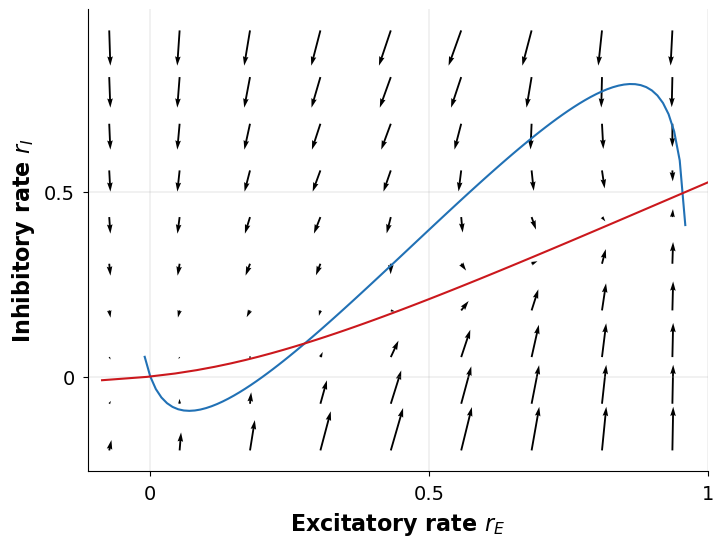

In [47]:
network_phase_plane = ExtendedNetworkEI()
ax = network_phase_plane.show_nullclines_lecture_plot()
network_phase_plane.show_vectors_in_phase_plane(ax=ax)

We now repeat the analysis from before, but now we can see how the overall vector field looks like. This can help you to further understand the dynamics and also to find 'interesting' starting positions for a given system.

### Task 7
You can try to vary the network below to find networks where you see oscillations, or limit cycles. 

In [35]:
extended_network_1 = ExtendedNetworkEI(I_E = 0.1, I_I = 0.5)
extended_network_2 = ExtendedNetworkEI(I_E = 0.1, I_I = 0.5)

extended_network_1.run_simulation(r_E0 = 0.32, r_I0 = 0.3)
extended_network_2.run_simulation(r_E0 = 0.6, r_I0 = 0.5)


def show_simulation_results(position_in_time):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))
    extended_network_1.show_sim_results_current_v_time_lecture_plot(linestyle = '-', ax = ax1, 
                                                           position_in_time = position_in_time,
                                                          color = '#984ea3')
    extended_network_1.show_sim_results_phase_plane( color = '#984ea3', ax = ax2, 
                                           position_in_time = position_in_time)
    extended_network_2.show_sim_results_current_v_time_lecture_plot(ax = ax1, linestyle = '--', 
                                                           position_in_time = position_in_time,
                                                          color = '#ff7f00')
    extended_network_2.show_sim_results_phase_plane(ax = ax2, color = '#ff7f00', linestyle = '--',
                                           position_in_time = position_in_time);
    
    extended_network_2.show_nullclines_lecture_plot(ax=ax2)
    extended_network_2.show_vectors_in_phase_plane(ax=ax2)
    
widgets.interactive(show_simulation_results, position_in_time = (0,200,5))

interactive(children=(IntSlider(value=100, description='position_in_time', max=200, step=5), Output()), _dom_c…

## [Solution 7](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_8/solutions/482fdd347c57468ecabbc67755a3fcd8.txt)

# BONUS

## Comparison of a spiking and rate network

We now look at how to compare spiking networks and rate networks.
Disclaimer - this is not really intended to be part of the teaching notebook. 

The idea is to setup a spiking neuron model that has intrinsic noise (see equations) and translate the activity arising from a network that consists of 1000 neurons (E and I) into the activity of a rate based model.

First, the f-i ciurve is fit to the output of the neuron. Then the rate-weights are calculated. 

In [36]:
# define single neuron properties

c_m = 10*nF
r_m = 1*Mohm
tau_m = c_m*r_m
tau_e = 5.26*ms
tau_i = 8*ms
E_i = -80*mV
E_e = 0*mV
E_l = -75*mV
v_threshold = -54 *mV
v_reset = -75*mV
g_l = 1/r_m
tau = 20*ms
sigma = 8*mV
refractory = 4*ms


eqs = '''
dv/dt = (i_e + i_i+ i_l+I_ext(t,i))/c_m + sigma*sqrt(2/tau)*xi : volt (unless refractory)
i_e = g_e * (E_e - v) : amp
i_i = g_i * (E_i - v) : amp
i_l = g_l * (E_l - v) : amp
dg_e/dt = -g_e / tau_e : siemens
dg_i/dt = -g_i / tau_i : siemens
'''

In [37]:
start_scope() # this opens our brian2 environment


def show_single_input_current_result(input_current = 24):  
    
    I_ext = TimedArray([[input_current*nA]], dt=defaultclock.dt) 
    single_neuron = NeuronGroup(1, eqs, threshold='v>v_threshold', reset='v=v_reset', refractory = refractory, method='milstein')
    
    spike_monitor = SpikeMonitor(single_neuron)
    voltage_monitor = StateMonitor(single_neuron, 'v', record=True)
    single_neuron.v = -60*mV
    
    run(100*ms)
    
    
    
    fig, (ax1,ax2) = plt.subplots(2, sharex=True)
    ax1.plot(spike_monitor.t/ms, spike_monitor.i, 'o', c='#2b8cbe')
    ax1.set(
        title = 'Spikes',
        yticks = [0],
        yticklabels = ['Neuron'])
    ax2.plot(voltage_monitor.t/ms, (voltage_monitor.v/mV)[0])
    ax2.set(
        ylabel = 'membrane voltage\n in mV')
    ax2.set(
        xlabel = 'Time in ms')
    

In [38]:
widgets.interactive(show_single_input_current_result, input_current = (0,50,1))

interactive(children=(IntSlider(value=24, description='input_current', max=50), Output()), _dom_classes=('widg…

In [40]:
def get_single_input_current_spikes(runtime, input_current = 24):  
    start_scope() # this opens our brian2 environment
    I_ext = TimedArray(input_current[None,:]*nA, dt=defaultclock.dt) 
    neurons = NeuronGroup(len(input_current), eqs, threshold='v>v_threshold', reset='v=v_reset',refractory = refractory, method='milstein')
    spike_monitor = SpikeMonitor(neurons)
    neurons.v = -60*mV
    
    run(runtime) 
    return spike_monitor.i[:]

runtime = 1_000 * ms
all_rates = []
all_currents = np.array([ii for ii in range(100)])
spikes = get_single_input_current_spikes(runtime = runtime, input_current = all_currents)

for current in all_currents:
    all_rates.append(spikes.tolist().count(current)/runtime)
    


def fit_nonlinearity(max_rate=124, alpha=0.28, theta=32):
    fig, ax = plt.subplots()
    ax.scatter(all_currents, all_rates)
    X = np.linspace(-0.1,all_currents[-1],200)
    ax.plot(X, max_rate*nonlinearity_f(X, alpha=alpha, theta=theta), color='#6baed6', linewidth = 3)
    
    ax.set(
        xlabel='Input current in nA',
        ylabel = 'Output firing rate in Hz')

widgets.interactive(fit_nonlinearity,max_rate=(0,200,1),alpha=(0,1,0.01),theta=(0,100,1))

interactive(children=(IntSlider(value=124, description='max_rate', max=200), FloatSlider(value=0.28, descripti…

### Task 8
Fit the non-linearity above and enter the parameters below

In [41]:
max_rate = 0
alpha = 0
theta = 0

## [Solution 8](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_8/solutions/d998387aebdb5f9605dc1191890502b8.txt)


In [42]:
n_neurons = 1000
n_E = int(n_neurons*0.8)
n_I = int(n_neurons*0.2)

g_EE = 0.8*nS
p_con_EE = 0.8

g_IE = 0.6*nS
p_con_IE = 0.85

g_EI = 6*nS
p_con_EI = 0.85

g_II = 3*nS
p_con_II = 0.9


def return_rate_weight(g_max, n_input, E_syn, tau_syn):
    V = -65*mV # assumption about mean membrane voltage
    P_rel = 1
    weight_factor = np.abs(g_max * P_rel * ( E_syn - V))
    
    
    X = np.linspace(0,1000,10_000) * ms
    
    def kernel(X):
        return np.exp(-X/tau_syn)
    
    dX = X[1]-X[0]
    average_kernel_value_per_second_per_spike = (np.sum(kernel(X)*dX)/(1000*ms) / (1*Hz))
    
    return n_input*weight_factor * average_kernel_value_per_second_per_spike/(nA/Hz)


w_EE = return_rate_weight(g_max=g_EE, n_input=p_con_EE*n_E, E_syn=E_e, tau_syn=tau_e)
w_IE = return_rate_weight(g_max=g_IE, n_input=p_con_IE*n_E, E_syn=E_e, tau_syn=tau_e)
w_EI = return_rate_weight(g_max=g_EI, n_input=p_con_EI*n_I, E_syn=E_i, tau_syn=tau_i)
w_II = return_rate_weight(g_max=g_II, n_input=p_con_II*n_I, E_syn=E_i, tau_syn=tau_i)

print(f'w_EE: {w_EE}, w_IE = {w_IE}, w_EI = {w_EI}, w_II = {w_II}')

w_EE: 0.17672223993635727, w_IE = 0.1408255349492847, w_EI = 0.12316667057229656, w_II = 0.0652058844206276


In [43]:
class EINetworkFit(ExtendedNetworkEI):
    """
    This class can create E-I networks, run simulations and visualize the results
    """
    def __init__(self, **params):
        '''This function is executed when we create an object from that class'''
        super(EINetworkFit, self).__init__(**params)
        
        
    def run_simulation_with_input(self,r_E0, r_I0, I_E, I_I, timesteps):
        
        self.t_list = [0]
        self.r_E_list = [r_E0]
        self.r_I_list = [r_I0]       
        
        for ii in range(timesteps):
            
            r_E = self.r_E_list[-1]
            r_I = self.r_I_list[-1]
            self.I_I = I_I[ii]
            self.I_E = I_E[ii] 
            
            dr_E_dt, dr_I_dt = self.dr_dt(r_E, r_I)
            
            # store in lists
            self.r_E_list.append(r_E + dr_E_dt)
            self.r_I_list.append(r_I + dr_I_dt)
            self.t_list.append(self.t_list[-1]+self.dt)

<AxesSubplot:xlabel='time in ms', ylabel='firing rate $r$'>

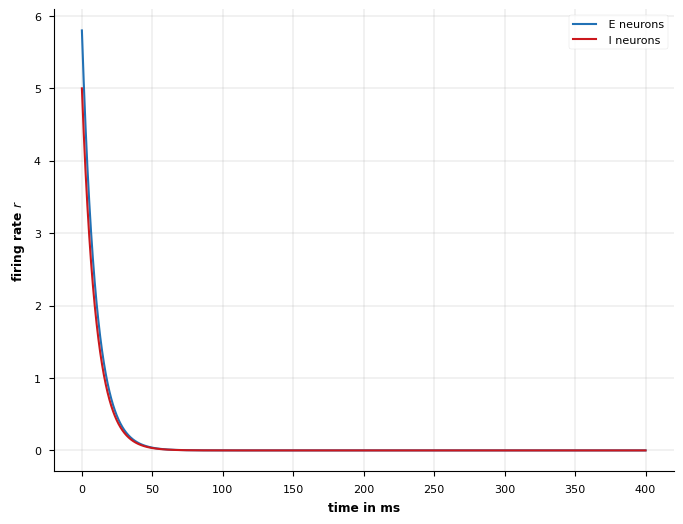

In [44]:
fig, ax = plt.subplots()


lecture_network = EINetworkFit(
    w_EE = w_EE ,
    w_EI = w_EI ,
    w_II = w_II ,
    w_IE = w_IE ,

    theta_E = theta,
    theta_I = theta,
    alpha_E = alpha,
    alpha_I = alpha,
    max_rate_E = max_rate,
    max_rate_I = max_rate,
    tau_E = 10,
    tau_I = 10,
    dt = 0.1)


inputs = np.vstack([5*randn(2000,n_neurons)+8,5*randn(2000,n_neurons)+14.5])
# we create the inputs that we can also feed into the spiking network (timesteps,n_neurons)


lecture_network.run_simulation_with_input(r_E0 = 5.8, r_I0 = 5, timesteps = 4000, 
                                          I_E = np.mean(inputs[:,:n_E],axis=1),
                                          I_I = np.mean(inputs[:,n_E:],axis=1))
# lecture_network.show_nullclines(ax=ax2)
lecture_network.show_sim_results(ax=ax)

### below we run the spiking network

In [45]:
start_scope() # this opens our brian2 environment


I_ext = TimedArray(inputs*nA, dt=defaultclock.dt)# white noise
neurons_exc = NeuronGroup(n_E, eqs, threshold='v>v_threshold', reset='v=v_reset',refractory = refractory, method='milstein')
neurons_inh = NeuronGroup(n_I, eqs, threshold='v>v_threshold', reset='v=v_reset',refractory = refractory, method='milstein')
neurons_exc.v = -60*mV
neurons_inh.v = -60*mV

e_e = Synapses(neurons_exc,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'rec_e_e')
e_e.connect(p=p_con_EE)
e_e.w = g_EE

i_e = Synapses(neurons_exc,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'rec_i_e')
i_e.connect(p=p_con_IE)
i_e.w = g_IE

e_i = Synapses(neurons_inh,neurons_exc, 'w : siemens', on_pre = 'g_i += w', name = 'rec_e_i')
e_i.connect(p=p_con_EI)
e_i.w = g_EI

i_i = Synapses(neurons_inh,neurons_inh, 'w : siemens', on_pre = 'g_i += w', name = 'rec_i_i')
i_i.connect(p=p_con_II)
i_i.w = g_II


M_e = SpikeMonitor(neurons_exc)
M_i = SpikeMonitor(neurons_inh)
rate_exc = PopulationRateMonitor(neurons_exc)
rate_inh = PopulationRateMonitor(neurons_inh)



run(400*ms)

# print (rate_exc.keys())



### Plot the results of the spiking network and the rate model

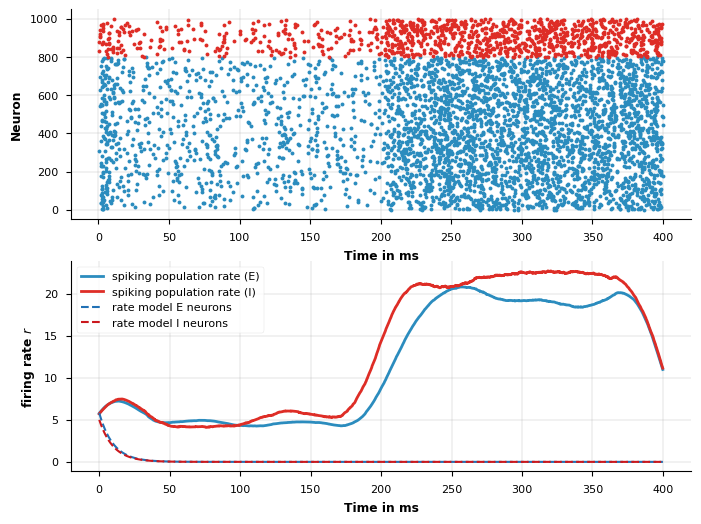

In [46]:
fig, (ax1,ax2) = plt.subplots(2)
ax1.plot(M_e.t/ms, M_e.i, '.', c='#2b8cbe')
ax1.plot(M_i.t/ms, M_i.i+n_neurons*0.8, '.', c='#de2d26')
ax1.set(
    ylabel = 'Neuron',
    xlabel = 'Time in ms')
ax2.plot(rate_exc.t/ms,rate_exc.smooth_rate(width=16*ms),c='#2b8cbe', label = 'spiking population rate (E)')
ax2.plot(rate_inh.t/ms,rate_inh.smooth_rate(width=16*ms),c='#de2d26',label = 'spiking population rate (I)')
lecture_network.show_sim_results(ax=ax2, linestyle='--', label = 'rate model')
ax2.set(
    xlabel = 'Time in ms')
ax2.legend()